In [1]:
#| hide
from diffusion_curvature.datasets import *
from diffusion_curvature.kernels import *
from nbdev import show_doc
%load_ext autoreload
%autoreload 2

# Diffusion Curvature

> Fast, pointwise graph curvature

>[!INFO] This code is currently in *early beta*. Some features, particularly those relating to dimension estimation and the construction of comparison spaces, are experimental and will likely change. Please report any issues you encounter to the Github Issues page.

Diffusion curvature is a pointwise extension of Ollivier-Ricci curvature, designed specifically for the often messy world of pointcloud data.
Its advantages include:

1. Unaffected by density fluctuations in data: it inherits the diffusion operator's denoising properties.
2. Fast, and scalable to millions of points: it depends only on matrix powering - no optimal transport required.

## Development Installation

This project is packaged with [Pixi](https://pixi.sh), a modern Poetry-like package manager from the makers of Mamba that supports both pip and conda packages. To install the dependencies and get the project running, follow these steps:

1. Install [Pixi](https://pixi.sh) with `brew install pixi` or (for the brave) `curl -fsSL https://pixi.sh/install.sh | bash`.
2. Run `pixi install` in the project root. This installs both the dependencies and the `diffusion_curvature` package itself.
3. Run `pixi run postinstall` to install a jupyter kernel and nbdev's git hooks (which erase troublesome notebook metadata to prevent git conflicts)

To access Pixi's virtual environment, run `pixi shell` in the project root, or (if you have a python script), run `pixi run python my_script.py`. 

## Usage

Diffusion Curvature uses scikit-learn style `fit_transform` syntax, with one subtlety: you must pass both a *graph* and a *graph former* (the function that created the graph). 

In [2]:
from diffusion_curvature.core import DiffusionCurvature, get_adaptive_graph, get_fixed_graph
from functools import partial

You can customize your 'graph former' using `partial`, like this. We supply two graph forming functions,  `get_fixed_graph` (which uses a standard gaussian kernel), and `get_adaptive_graph` (which adaptively sets the kernel bandwidth at each point based on the distance to the kth nearest neighbor). For accurately computing signed curvatures, we recommend using `get_fixed_graph` and tuning the bandwidth yourself to the data, as adaptively tuned bandwidths make comparing between spaces of different curvature hard.

In [60]:
# graph_former = partial(get_fixed_graph, sigma = None, alpha = 1)
graph_former = partial(get_adaptive_graph, alpha = 1)

Which can then be easily applied to data

In [61]:
X_torus, ks_torus = torus(2000)
G_torus = graph_former(X_torus)

2024-04-18 13:09:32,185:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


Curvature is computed by the `DiffusionCurvature` class. All of the defaults are sane.

The only thing you need to pass at initialization is your graphformer.

In [63]:
DC = DiffusionCurvature(
    graph_former=graph_former
)

To get curvature, call `.fit_transform` and supply the intrinsic dimension (or a guess at it).

In [64]:
ks = DC.fit_transform(G_torus, dim=2) # note: this is the *intrinsic* dimension of the data

2024-04-18 13:09:42,787:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


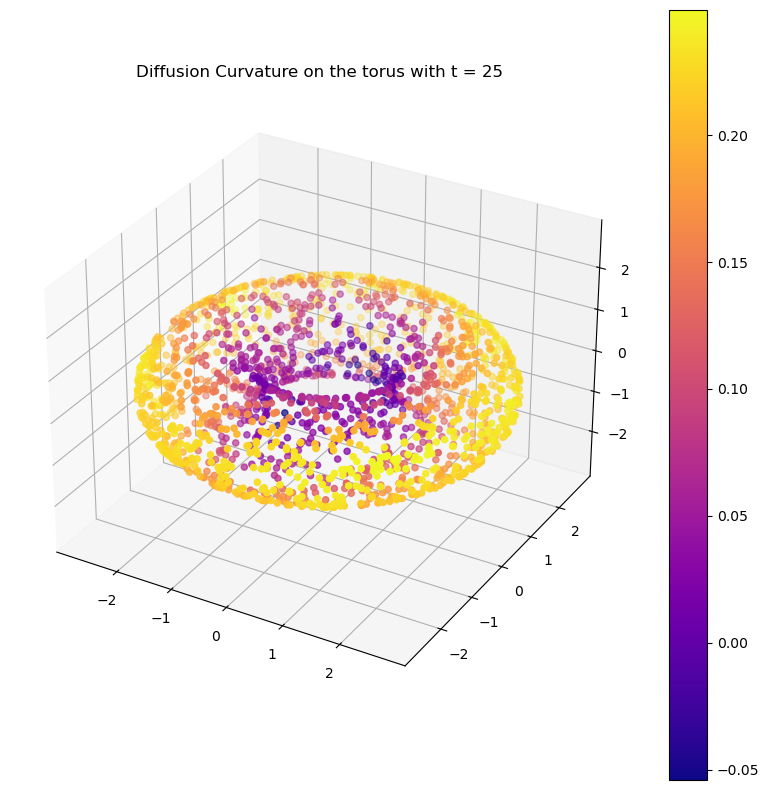

In [65]:
plot_3d(X_torus, ks, colorbar=True, title=f"Diffusion Curvature on the torus with t = {DC.t}")

The main parameter in the algorithm is $t$, the diffusion time. Roughly speaking, $t$ controls the scale at which curvature is measured. 

You might have noticed that we never supplied $t$ above. Fear not —— if left blank, Diffusion Curvature estimates the best $t$ by looking at the entropy of the eigenvalues of the diffusion matrix over time. You can see what it finds with:

In [66]:
DC.t

25

We recommend playing with this value.

In some situations, an *unsigned* curvature is preferable — and much easier computationally. To get this, just pass `unsigned=True`.

In [67]:
ks = DC.fit_transform(G_torus, t=25, dim=2, unsigned=True)


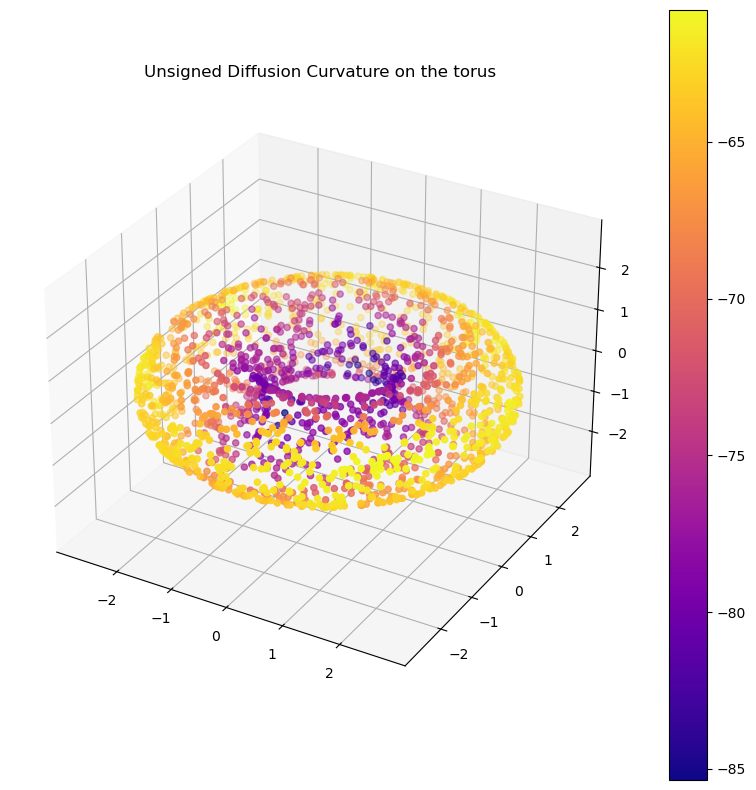

In [69]:
plot_3d(X_torus, ks, colorbar=True, title="Unsigned Diffusion Curvature on the torus")

Don't be alarmed if the signs here are negative. The higher numbers are more positively curved, the lower more negatively curved.